###  IBM Data Science Final Project

# Forming a Recommender System on the Basis of K-Means Similarity Metrics

_Louis X. Meikle_

## Introduction

I live in London and if there's one thing I've realised by living here a good two decades is that London is diverse, varied and vibrant in it's culture; a true synthesis of identies and ideas. So, accordingly, I've wondered about how to apply my data science skillset to my city. Then, I thought "How can I make sense of this madness and how can I help people with my conclusions?". I then considered that could create a system that allows people to put in a place they already like and get a reccomendation out!
Hopefully, by using this, I should be able to give people fair reccomendations so that they have a good time out in London!

## Business Problem

Let us say that a ficticous business (which I will hence refer to as Mercury Travel Ltd) wants to create a recommender system that allows for it's clients to be recommeded a location in London to go to based on previous places they liked. This is done because their previous method (which involved taking local and possibly biased tips) was ineffecitive and often led clients to unpleasant locations. The goal here it to create a recommendation system that can accurately and reliably give a recommendation to someone given their prior locations.

I will be using K-Means clustering for my segmentation of different groups in London as it produces clusters with high similarity and it is also a fairly reliable approach so it is fairly decent for a recommender system. I am also using an item-based approach to constructing my recommender system not only because I can't gain data about individual preferences at the moment but also because locations change less frequently than user preferences so the system will generally be more stable.

(For a summary for the differences in recommender systems see below:)

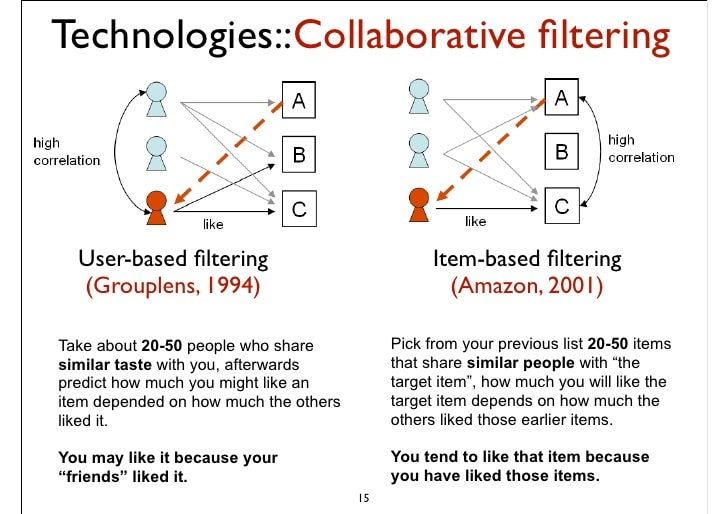

## Data

My data will be retrieved from the Foursquare API as it has a comprehensive list of many different types of locations in London as well as tangential data such as tips and reviews that could help me to clean my data set. Foursquare can have some slight problems in reliability given that data is still crowdsourced so we will have to implement some cleaning methods for the data to make sure that it allows for a well functioning model. After all, if we have a poor input we're going to get a poor output.

_Library Import:_

In [39]:
import pandas as pd
import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from pandas.io.json import json_normalize
import re
import json
import requests
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
!pip install folium==0.5.0
import folium
from folium import Map
from folium.map import Layer, FeatureGroup,LayerControl,Marker
from folium.plugins import HeatMap
from branca.element import Figure

Firstly, let's put in our details for accessing the Foursquare API. I'm also going to say to set the values near 'London, UK'. This generally puts us on what many maps consider to be the centre of London; Charing Cross Station.

I have also specified some category IDs to slim down my search. These IDs are
1. Arts and Entertainment
2. Events
3. Nightlife
4. Outdoors and Recreation
5. Shopping and Services

Please note that I have actively disqualified the following types of services:
1. College and University (No one is looking to visit location like this or, at least, very few people are.)
2. Food (I considered putting places to eat in there but I felt it wouldn't be appropriate or seemed like an entirely different project. Let's focus just on 'places to go')
3. Professional and Other Places (This included hospitals, government buildings and, oddly enough, funeral homes!)
4. Residences (Does what it says on the tin. We don't need to look for this.)
5. Travel and Transport (Barely anyone is going to go out to see a transport link.)



In [2]:
CLIENT_ID = 'DVV4ININKOLFQTZSX1KHHWJMSDQ2SWM3B4OARGU0DSJM3VIJ'
CLIENT_SECRET = 'RVD53QZWAEB5N3L1D5DKQLRAWEBXSRHS5SDJMYRVNHBYDO4B'
ACCESS_TOKEN = 'EVY0T1QPQA2C2UD55WWXGTB0NIPNMK0TXC30WMKAZ0KJFOPZ'
VERSION = '20180604'
LIMIT= 200
radius = 100000
near = 'London'
category_id1 = '4d4b7104d754a06370d81259' #Arts and Entertainment
category_id2 = '4d4b7105d754a06373d81259' #Events
category_id3 = '4d4b7105d754a06376d81259' #Nightlife
category_id4 = '4d4b7105d754a06377d81259' #Outdoors and Recreation
category_id5 = '4d4b7105d754a06378d81259' #Shopping and Services

Let's now define the URL we're going to be extract our data from and have a look at our data!

In [3]:
url1 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near, category_id1)
results1 = requests.get(url1).json()
venues1 = results1['response']['venues']
df1 = json_normalize(venues1)
df1.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.formattedAddress':'location_formattedAddress'}, inplace = True)
df1.head(100000)

,id,name,categories,referralId,hasPerk,location.address,location_lat,location_lng,location.labeledLatLngs,location.postalCode,location.cc,location.city,location.state,location.country,location_formattedAddress,venuePage.id,location.crossStreet,location.neighborhood
0,4ac518cdf964a520e6a520e3,National Gallery,"[{'id': '4bf58dd8d48988d18f941735', 'name': 'A...",v-1627077281,False,Trafalgar Sq,51.508876,-0.128478,"[{'label': 'display', 'lat': 51.50887601013219...",WC2N 5DN,GB,London,Greater London,United Kingdom,"[Trafalgar Sq, London, Greater London, WC2N 5D...",51313653,NaN,NaN
1,52fe72e0498e6484322373d8,180 The Strand,"[{'id': '4bf58dd8d48988d1e2931735', 'name': 'A...",v-1627077281,False,180 The Strand,51.512671,-0.115009,"[{'label': 'display', 'lat': 51.51267138626463...",WC2R 1EA,GB,London,Greater London,United Kingdom,"[180 The Strand, London, Greater London, WC2R ...",NaN,NaN,NaN
2,4ac518cff964a52063a620e3,Somerset House,"[{'id': '4bf58dd8d48988d171941735', 'name': 'E...",v-1627077281,False,Strand,51.510786,-0.117899,"[{'label': 'display', 'lat': 51.51078575130956...",WC2R 1LA,GB,London,Greater London,United Kingdom,"[Strand, London, Greater London, WC2R 1LA, Uni...",45884508,NaN,NaN
3,4bd195aa9854d13a9abff94d,Marble Arch,"[{'id': '4bf58dd8d48988d12d941735', 'name': 'M...",v-1627077281,False,Oxford St,51.513446,-0.158270,NaN,NaN,GB,London,Greater London,United Kingdom,"[Oxford St (at Park Ln), London, Greater Londo...",NaN,at Park Ln,Mayfair
4,4ac518eaf964a52007ac20e3,The O2 Arena,"[{'id': '4bf58dd8d48988d1e5931735', 'name': 'M...",v-1627077281,False,Peninsula Sq,51.502827,0.003182,"[{'label': 'display', 'lat': 51.502827, 'lng':...",SE10 0DX,GB,Greenwich,Greater London,United Kingdom,"[Peninsula Sq (at Millennium Way), Greenwich, ...",NaN,at Millennium Way,NaN
5,60f6b798e0aece0c9a6832ba,Unit 1 Gallery Workshop,"[{'id': '4bf58dd8d48988d1e2931735', 'name': 'A...",v-1627077281,False,NaN,51.511864,-0.219124,"[{'label': 'display', 'lat': 51.511864, 'lng':...",W10 6TP,GB,NaN,NaN,United Kingdom,"[W10 6TP, United Kingdom]",NaN,NaN,NaN
6,60bbca8bb20f273e8003a1ba,Van Goghalive The Experience,"[{'id': '4bf58dd8d48988d1e2931735', 'name': 'A...",v-1627077281,False,kenisgton gardens,51.502668,-0.176537,"[{'label': 'display', 'lat': 51.502668, 'lng':...",W8,GB,London,Greater London,United Kingdom,"[kenisgton gardens, London, Greater London, W8...",NaN,NaN,NaN
7,54635ff6498ef9c2cf16553a,West Berkshire museum,"[{'id': '4bf58dd8d48988d190941735', 'name': 'H...",v-1627077281,False,The Wharf,51.456440,-1.048156,"[{'label': 'display', 'lat': 51.45644003630102...",NaN,GB,Newbury,West Berkshire,United Kingdom,"[The Wharf, Newbury, West Berkshire, United Ki...",NaN,NaN,NaN
8,4f8f318be4b0e77df43bba76,Chiswick Memorial Club,"[{'id': '4bf58dd8d48988d1f1931735', 'name': 'G...",v-1627077281,False,NaN,51.491083,-0.261684,"[{'label': 'display', 'lat': 51.49108256913276...",NaN,GB,NaN,NaN,United Kingdom,[United Kingdom],NaN,NaN,NaN
9,50190be8e4b044669f12e8ac,Cricket Pitch,"[{'id': '4bf58dd8d48988d18a941735', 'name': 'C...",v-1627077281,False,Chiswick House and Gardens,51.483321,-0.263857,"[{'label': 'display', 'lat': 51.48332071749872...",NaN,GB,NaN,NaN,United Kingdom,"[Chiswick House and Gardens, United Kingdom]",NaN,NaN,NaN


In [4]:
url2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near, category_id2)
results2 = requests.get(url2).json()
venues2 = results2['response']['venues']
df2 = json_normalize(venues2)
df2.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.formattedAddress':'location_formattedAddress'}, inplace = True)
df2.head(100000)

,id,name,categories,referralId,hasPerk,location_lat,location_lng,location.labeledLatLngs,location.postalCode,location.cc,location.city,location.state,location.country,location_formattedAddress,location.address,location.crossStreet,location.neighborhood
0,60b53e881a5c47058e7fd786,Between The Bridges,"[{'id': '5267e4d9e4b0ec79466e48c7', 'name': 'F...",v-1627077284,False,51.504866,-0.117962,"[{'label': 'display', 'lat': 51.504866, 'lng':...",SE1 7PB,GB,London,Greater London,United Kingdom,"[London, Greater London, SE1 7PB, United Kingdom]",NaN,NaN,NaN
1,60f352cf905f5b21a74adfce,Underbelly Spiegeltent,"[{'id': '5267e4d9e4b0ec79466e48c7', 'name': 'F...",v-1627077284,False,51.516464,-0.144994,"[{'label': 'display', 'lat': 51.516464, 'lng':...",W1G,GB,London,Greater London,United Kingdom,"[Cavendish Square Gardens (Cavendish Square), ...",Cavendish Square Gardens,Cavendish Square,NaN
2,60c4e3411704c20c3ef40cc0,UEFA Festival London 2020,"[{'id': '5267e4d9e4b0ec79466e48c7', 'name': 'F...",v-1627077284,False,51.504415,-0.077769,"[{'label': 'display', 'lat': 51.504415, 'lng':...",SE1,GB,London,Greater London,United Kingdom,"[Potters Field, London, Greater London, SE1, U...",Potters Field,NaN,NaN
3,60d748701dbe9e357fd6ec1d,Real Ale Festival,"[{'id': '5267e4d9e4b0ec79466e48c7', 'name': 'F...",v-1627077284,False,50.705536,-1.214121,"[{'label': 'display', 'lat': 50.705536, 'lng':...",PO33 4DS,GB,Havenstreet,Isle of Wight,United Kingdom,"[Havenstreet, Isle of Wight, PO33 4DS, United ...",NaN,NaN,NaN
4,60e0512c3b49271c4105d440,Friends Fest,"[{'id': '5267e4d9e4b0ec79466e48c7', 'name': 'F...",v-1627077284,False,51.457943,-0.152787,"[{'label': 'display', 'lat': 51.457943, 'lng':...",SW4,GB,NaN,NaN,United Kingdom,"[SW4, United Kingdom]",NaN,NaN,NaN
5,60b2ababa454f60d29dec465,Unit HQ,"[{'id': '5267e4d9e4b0ec79466e48c8', 'name': 'O...",v-1627077284,False,51.513079,-0.147977,"[{'label': 'display', 'lat': 51.513079, 'lng':...",W1K 5AB,GB,London,Greater London,United Kingdom,"[Davies Mews, London, Greater London, W1K 5AB,...",Davies Mews,NaN,NaN
6,5b4f48ddee7120002c1dbcbf,River House - The Lounge,"[{'id': '5267e4d9e4b0ec79466e48c8', 'name': 'O...",v-1627077284,False,51.482752,-0.146331,"[{'label': 'display', 'lat': 51.482752, 'lng':...",SW11 8EH,GB,London,Greater London,United Kingdom,"[Scott House (11 Circus road west), London, Gr...",Scott House,11 Circus road west,NaN
7,60cdb092dbc9365fec69ba55,St Albans Inflatable 5K,"[{'id': '5bae9231bedf3950379f89c5', 'name': 'S...",v-1627077284,False,51.816054,-0.412113,"[{'label': 'display', 'lat': 51.816054, 'lng':...",AL3,GB,St Albans,Hertfordshire,United Kingdom,"[St Albans, Hertfordshire, AL3, United Kingdom]",NaN,NaN,NaN
8,60d709932c321250803c3764,London Classic Car Show,"[{'id': '5bae9231bedf3950379f89c3', 'name': 'T...",v-1627077284,False,51.476324,-0.316849,"[{'label': 'display', 'lat': 51.476324, 'lng':...",TW8,GB,Brentford,Greater London,United Kingdom,"[Brentford, Greater London, TW8, United Kingdom]",NaN,NaN,NaN
9,60c44d71142e0e52f196d912,Weeley Car Boot,"[{'id': '5267e4d9e4b0ec79466e48c8', 'name': 'O...",v-1627077284,False,51.859733,1.105614,"[{'label': 'display', 'lat': 51.859733, 'lng':...",CO16 9AG,GB,Clacton-on-Sea,Essex,United Kingdom,"[Weeley Car Boot (Colchester Road), Clacton-on...",Weeley Car Boot,Colchester Road,NaN


In [5]:
url3 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near, category_id3)
results3 = requests.get(url3).json()
venues3 = results3['response']['venues']
df3 = json_normalize(venues3)
df3.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.formattedAddress':'location_formattedAddress'}, inplace = True)
df3.head(100000)

,id,name,categories,referralId,hasPerk,location.address,location_lat,location_lng,location.labeledLatLngs,location.postalCode,location.cc,location.city,location.state,location.country,location_formattedAddress,venuePage.id,location.neighborhood,location.crossStreet
0,4ac518c5f964a520c7a420e3,Pub on the Park,"[{'id': '4bf58dd8d48988d11b941735', 'name': 'P...",v-1627077291,False,19 Martello St,51.541974,-0.058280,"[{'label': 'display', 'lat': 51.54197424574372...",E8 3PE,GB,London,Greater London,United Kingdom,"[19 Martello St, London, Greater London, E8 3P...",1360226205,NaN,NaN
1,4baa57e6f964a5202b613ae3,Halfway 2 Heaven,"[{'id': '4bf58dd8d48988d1d8941735', 'name': 'G...",v-1627077291,False,7 Duncannon St,51.508426,-0.126516,"[{'label': 'display', 'lat': 51.5084259850165,...",WC2N 4JF,GB,Charing Cross,Greater London,United Kingdom,"[7 Duncannon St, Charing Cross, Greater London...",NaN,NaN,NaN
2,4e805fb2dab41c952c505ffc,Novikov,"[{'id': '4bf58dd8d48988d142941735', 'name': 'A...",v-1627077291,False,50a Berkeley St,51.507767,-0.142850,"[{'label': 'display', 'lat': 51.50776710376237...",W1J 8HA,GB,London,Greater London,United Kingdom,"[50a Berkeley St, London, Greater London, W1J ...",121043084,Mayfair,NaN
3,510555ade4b0d770cf17435c,Cigar Terrace,"[{'id': '4bf58dd8d48988d133951735', 'name': 'R...",v-1627077291,False,11 Knightsbridge,51.502694,-0.153785,"[{'label': 'display', 'lat': 51.50269404933004...",SW1X 7LY,GB,London,Greater London,United Kingdom,"[11 Knightsbridge, London, Greater London, SW1...",422742789,NaN,NaN
4,5db438898813f20007ff3b1b,Mikkeller Brewpub London,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",v-1627077291,False,37-39 Exmouth Market,51.525919,-0.109130,"[{'label': 'display', 'lat': 51.525919, 'lng':...",EC1R 4QL,GB,London,Greater London,United Kingdom,"[37-39 Exmouth Market, London, Greater London,...",NaN,NaN,NaN
5,4ac518d8f964a52085a820e3,Scott's,"[{'id': '4bf58dd8d48988d1ce941735', 'name': 'S...",v-1627077291,False,20 Mount St,51.509916,-0.150836,"[{'label': 'display', 'lat': 51.509916, 'lng':...",W1K 2HE,GB,London,Greater London,United Kingdom,"[20 Mount St, London, Greater London, W1K 2HE,...",NaN,NaN,NaN
6,4acdb591f964a520c7cc20e3,Gordon's Wine Bar,"[{'id': '4bf58dd8d48988d123941735', 'name': 'W...",v-1627077291,False,47 Villiers St,51.507911,-0.123293,"[{'label': 'display', 'lat': 51.5079110929777,...",WC2N 6NE,GB,London,Greater London,United Kingdom,"[47 Villiers St (Watergate Walk), London, Grea...",NaN,NaN,Watergate Walk
7,5a3a9f710531e85f7d8b46a3,The Arnos Arms,"[{'id': '56aa371ce4b08b9a8d57356c', 'name': 'B...",v-1627077291,False,338 Bowes Road,51.616044,-0.132136,"[{'label': 'display', 'lat': 51.616044, 'lng':...",N11 1AN,GB,London,Greater London,United Kingdom,"[338 Bowes Road (Arnos Grove), London, Greater...",NaN,NaN,Arnos Grove
8,5943c9e0be57631e13c5bd9a,The Hothampton Arms,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",v-1627077291,False,49-51 London Rd,50.786193,-0.674378,"[{'label': 'display', 'lat': 50.78619323356253...",PO21 1LF,GB,Bognor Regis,West Sussex,United Kingdom,"[49-51 London Rd, Bognor Regis, West Sussex, P...",NaN,NaN,NaN
9,4d4dc9c5b887a1cda8fbbfa0,Waterloo,"[{'id': '4bf58dd8d48988d11a941735', 'name': 'O...",v-1627077291,False,NaN,50.783254,-0.678764,"[{'label': 'display', 'lat': 50.783254, 'lng':...",NaN,GB,NaN,NaN,United Kingdom,[United Kingdom],NaN,NaN,NaN


In [6]:
url4 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near, category_id4)
results4 = requests.get(url4).json()
venues4 = results4['response']['venues']
df4 = json_normalize(venues4)
df4.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.formattedAddress':'location_formattedAddress'}, inplace = True)
df4.head(100000)

,id,name,categories,referralId,hasPerk,location.address,location_lat,location_lng,location.labeledLatLngs,location.postalCode,location.cc,location.city,location.state,location.country,location_formattedAddress,location.crossStreet,venuePage.id,location.neighborhood
0,4ac518cef964a520f9a520e3,Trafalgar Square,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",v-1627077296,False,Trafalgar Sq,51.507987,-0.128048,"[{'label': 'display', 'lat': 51.507987, 'lng':...",WC2N 5DX,GB,London,Greater London,United Kingdom,"[Trafalgar Sq, London, Greater London, WC2N 5D...",NaN,NaN,NaN
1,4ac518d2f964a52026a720e3,Hyde Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1627077296,False,Serpentine Rd,51.507188,-0.163731,"[{'label': 'display', 'lat': 51.50718789261791...",W2 2TP,GB,London,Greater London,United Kingdom,"[Serpentine Rd, London, Greater London, W2 2TP...",NaN,NaN,NaN
2,4bc9d8eb937ca593e96aa692,Greenwich Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1627077296,False,Maze Hill,51.477521,0.000858,"[{'label': 'display', 'lat': 51.47752077622347...",SE10 9NF,GB,London,Greater London,United Kingdom,"[Maze Hill (Charlton Way), Greenwich, Greater ...",Charlton Way,NaN,NaN
3,4ac518d1f964a520c3a620e3,Leicester Square,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",v-1627077296,False,Leicester Sq,51.510519,-0.130098,"[{'label': 'display', 'lat': 51.5105186594565,...",WC2H 7NA,GB,London,Greater London,United Kingdom,"[Leicester Sq, London, Greater London, WC2H 7N...",NaN,NaN,NaN
4,4b233922f964a520785424e3,Regent's Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1627077296,False,Chester Rd,51.530479,-0.153766,"[{'label': 'display', 'lat': 51.53047945949403...",NW1 4NR,GB,London,Greater London,United Kingdom,"[Chester Rd, London, Greater London, NW1 4NR, ...",NaN,42154907,NaN
5,4c9c6a059c48236a1cb14dee,Piccadilly Circus,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",v-1627077296,False,Piccadilly,51.509961,-0.134652,"[{'label': 'display', 'lat': 51.50996110016709...",W1D 1NN,GB,London,Greater London,United Kingdom,"[Piccadilly (Regent St), London, Greater Londo...",Regent St,NaN,Piccadilly
6,4aec080af964a5203ec521e3,Brockwell Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1627077296,False,Dulwich Rd,51.450931,-0.106065,"[{'label': 'display', 'lat': 51.45093143256645...",SE24 0PA,GB,Herne Hill,Greater London,United Kingdom,"[Dulwich Rd (Norwood Rd), Herne Hill, Greater ...",Norwood Rd,NaN,NaN
7,4b7ffcd1f964a520e94830e3,Kensington Gardens,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1627077296,False,Kensington Rd,51.506766,-0.180373,"[{'label': 'display', 'lat': 51.50676585336450...",W2 3XA,GB,London,Greater London,United Kingdom,"[Kensington Rd (Bayswater Rd), London, Greater...",Bayswater Rd,NaN,Knightsbridge and Belgravia
8,4ba5e970f964a520ef2839e3,Vauxhall Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",v-1627077296,False,Fentiman Rd,51.482733,-0.122180,"[{'label': 'display', 'lat': 51.48273255637877...",SW8 1QY,GB,London,Greater London,United Kingdom,"[Fentiman Rd, London, Greater London, SW8 1QY,...",NaN,NaN,"Vauxhall, London, Greater London"
9,4abe4502f964a520558c20e3,Buckingham Palace,"[{'id': '52e81612bcbc57f1066b7a14', 'name': 'P...",v-1627077296,False,Buckingham Palace Rd,51.500956,-0.143123,"[{'label': 'display', 'lat': 51.5009557396122,...",SW1A 1AA,GB,London,Greater London,United Kingdom,"[Buckingham Palace Rd, London, Greater London,...",NaN,NaN,NaN


In [7]:
url5 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near, category_id5)
results5 = requests.get(url5).json()
venues5 = results5['response']['venues']
df5 = json_normalize(venues5)
df5.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.formattedAddress':'location_formattedAddress'}, inplace = True)
df5.head(100000)

,id,name,categories,referralId,hasPerk,location.address,location_lat,location_lng,location.labeledLatLngs,location.postalCode,location.cc,location.city,location.state,location.country,location_formattedAddress,location.crossStreet,location.neighborhood,venuePage.id
0,4ba6419bf964a520b23f39e3,Covent Garden Market,"[{'id': '5744ccdfe4b0c0459246b4dc', 'name': 'S...",v-1627077301,False,The Piazza,51.511977,-0.122799,"[{'label': 'display', 'lat': 51.51197662809401...",WC2E 8RF,GB,London,Greater London,United Kingdom,"[The Piazza, London, Greater London, WC2E 8RF,...",NaN,NaN,NaN
1,4abf8c03f964a520079120e3,Harrods,"[{'id': '4bf58dd8d48988d1f6941735', 'name': 'D...",v-1627077301,False,87-135 Brompton Rd,51.499386,-0.162896,"[{'label': 'display', 'lat': 51.49938621399249...",SW1X 7XL,GB,London,Greater London,United Kingdom,"[87-135 Brompton Rd, London, Greater London, S...",NaN,NaN,NaN
2,4ae5b238f964a52087a121e3,Selfridges & Co,"[{'id': '4bf58dd8d48988d1f6941735', 'name': 'D...",v-1627077301,False,400 Oxford St,51.514640,-0.152864,"[{'label': 'display', 'lat': 51.51464, 'lng': ...",W1A 1AB,GB,London,Greater London,United Kingdom,"[400 Oxford St, London, Greater London, W1A 1A...",NaN,NaN,NaN
3,4ac518ecf964a52071ac20e3,Harvey Nichols,"[{'id': '4bf58dd8d48988d1f6941735', 'name': 'D...",v-1627077301,False,109-125 Knightsbridge,51.501543,-0.159742,"[{'label': 'display', 'lat': 51.50154346295545...",SW1X 7RJ,GB,London,Greater London,United Kingdom,"[109-125 Knightsbridge, London, Greater London...",NaN,NaN,NaN
4,60f6ca28be7db520952c063d,Autoglass,"[{'id': '52f2ab2ebcbc57f1066b8b44', 'name': 'A...",v-1627077301,False,57a Croydon Rd,51.367176,-0.124123,"[{'label': 'display', 'lat': 51.367176, 'lng':...",CR0 4WQ,GB,Croydon,Greater London,United Kingdom,"[57a Croydon Rd, Croydon, Greater London, CR0 ...",NaN,NaN,NaN
5,5ab7c1c8b9a5a8426f69e236,Charlton Riverside Place,"[{'id': '5744ccdfe4b0c0459246b4dc', 'name': 'S...",v-1627077301,False,Woolwich Rd,51.487519,0.027392,"[{'label': 'display', 'lat': 51.487519, 'lng':...",SE7 7AJ,GB,London,Greater London,United Kingdom,"[Woolwich Rd, London, Greater London, SE7 7AJ,...",NaN,NaN,NaN
6,5093f0bce4b02e00460cb913,West India Quay Centre,"[{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...",v-1627077301,False,Hertsmere Rd,51.507287,-0.022917,"[{'label': 'display', 'lat': 51.50728672392945...",E14 4AE,GB,London,Greater London,United Kingdom,"[Hertsmere Rd, West India Quay, Greater London...",NaN,NaN,NaN
7,4b7d16b8f964a52049ae2fe3,Warner Bros. Studios Leavesden,"[{'id': '56aa371be4b08b9a8d573523', 'name': 'F...",v-1627077301,False,Warner Dr,51.693127,-0.417179,"[{'label': 'display', 'lat': 51.69312742424265...",WD25 7LR,GB,Leavesden Green,Hertfordshire,United Kingdom,"[Warner Dr (Aerodrome Way), Leavesden Green, H...",Aerodrome Way,NaN,NaN
8,4d2c37c2ebacb1f7f1711250,Arena Retail Park,"[{'id': '5744ccdfe4b0c0459246b4dc', 'name': 'S...",v-1627077301,False,Green Lanes,51.576078,-0.098235,"[{'label': 'display', 'lat': 51.57607756312697...",N4 1DR,GB,Harringay,Greater London,United Kingdom,"[Green Lanes, Harringay, Greater London, N4 1D...",NaN,NaN,NaN
9,4ac518f3f964a520d3ae20e3,Cardinal Place,"[{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...",v-1627077301,False,76-98 Victoria St,51.497234,-0.140979,"[{'label': 'display', 'lat': 51.49723397444029...",SW1E 5JL,GB,Victoria,Greater London,United Kingdom,"[76-98 Victoria St, Victoria, Greater London, ...",NaN,NaN,NaN


Alright then! This seems OK for now. We've got our venues plus information about location, address, business type and a whole lot more. Now let's smash all our tables together and make one big table!

In [8]:
dataframes = [df1, df2, df3, df4, df5]
dfX = pd.concat(dataframes)
dfX

,id,name,categories,referralId,hasPerk,location.address,location_lat,location_lng,location.labeledLatLngs,location.postalCode,location.cc,location.city,location.state,location.country,location_formattedAddress,venuePage.id,location.crossStreet,location.neighborhood
0,4ac518cdf964a520e6a520e3,National Gallery,"[{'id': '4bf58dd8d48988d18f941735', 'name': 'A...",v-1627077281,False,Trafalgar Sq,51.508876,-0.128478,"[{'label': 'display', 'lat': 51.50887601013219...",WC2N 5DN,GB,London,Greater London,United Kingdom,"[Trafalgar Sq, London, Greater London, WC2N 5D...",51313653,NaN,NaN
1,52fe72e0498e6484322373d8,180 The Strand,"[{'id': '4bf58dd8d48988d1e2931735', 'name': 'A...",v-1627077281,False,180 The Strand,51.512671,-0.115009,"[{'label': 'display', 'lat': 51.51267138626463...",WC2R 1EA,GB,London,Greater London,United Kingdom,"[180 The Strand, London, Greater London, WC2R ...",NaN,NaN,NaN
2,4ac518cff964a52063a620e3,Somerset House,"[{'id': '4bf58dd8d48988d171941735', 'name': 'E...",v-1627077281,False,Strand,51.510786,-0.117899,"[{'label': 'display', 'lat': 51.51078575130956...",WC2R 1LA,GB,London,Greater London,United Kingdom,"[Strand, London, Greater London, WC2R 1LA, Uni...",45884508,NaN,NaN
3,4bd195aa9854d13a9abff94d,Marble Arch,"[{'id': '4bf58dd8d48988d12d941735', 'name': 'M...",v-1627077281,False,Oxford St,51.513446,-0.158270,NaN,NaN,GB,London,Greater London,United Kingdom,"[Oxford St (at Park Ln), London, Greater Londo...",NaN,at Park Ln,Mayfair
4,4ac518eaf964a52007ac20e3,The O2 Arena,"[{'id': '4bf58dd8d48988d1e5931735', 'name': 'M...",v-1627077281,False,Peninsula Sq,51.502827,0.003182,"[{'label': 'display', 'lat': 51.502827, 'lng':...",SE10 0DX,GB,Greenwich,Greater London,United Kingdom,"[Peninsula Sq (at Millennium Way), Greenwich, ...",NaN,at Millennium Way,NaN
5,60f6b798e0aece0c9a6832ba,Unit 1 Gallery Workshop,"[{'id': '4bf58dd8d48988d1e2931735', 'name': 'A...",v-1627077281,False,NaN,51.511864,-0.219124,"[{'label': 'display', 'lat': 51.511864, 'lng':...",W10 6TP,GB,NaN,NaN,United Kingdom,"[W10 6TP, United Kingdom]",NaN,NaN,NaN
6,60bbca8bb20f273e8003a1ba,Van Goghalive The Experience,"[{'id': '4bf58dd8d48988d1e2931735', 'name': 'A...",v-1627077281,False,kenisgton gardens,51.502668,-0.176537,"[{'label': 'display', 'lat': 51.502668, 'lng':...",W8,GB,London,Greater London,United Kingdom,"[kenisgton gardens, London, Greater London, W8...",NaN,NaN,NaN
7,54635ff6498ef9c2cf16553a,West Berkshire museum,"[{'id': '4bf58dd8d48988d190941735', 'name': 'H...",v-1627077281,False,The Wharf,51.456440,-1.048156,"[{'label': 'display', 'lat': 51.45644003630102...",NaN,GB,Newbury,West Berkshire,United Kingdom,"[The Wharf, Newbury, West Berkshire, United Ki...",NaN,NaN,NaN
8,4f8f318be4b0e77df43bba76,Chiswick Memorial Club,"[{'id': '4bf58dd8d48988d1f1931735', 'name': 'G...",v-1627077281,False,NaN,51.491083,-0.261684,"[{'label': 'display', 'lat': 51.49108256913276...",NaN,GB,NaN,NaN,United Kingdom,[United Kingdom],NaN,NaN,NaN
9,50190be8e4b044669f12e8ac,Cricket Pitch,"[{'id': '4bf58dd8d48988d18a941735', 'name': 'C...",v-1627077281,False,Chiswick House and Gardens,51.483321,-0.263857,"[{'label': 'display', 'lat': 51.48332071749872...",NaN,GB,NaN,NaN,United Kingdom,"[Chiswick House and Gardens, United Kingdom]",NaN,NaN,NaN


In [9]:
dfX.shape

(200, 18)

Ok then. We seem to have retrieved the location data for 200 venues. Due to Foursquare limiting my number of calls, I can't get the data from every institution in London, so this will have to do for now.

Let's have a look at the names of institutions here to see if we can spot any outliers:

In [10]:
dfX.name

0                          National Gallery
1                            180 The Strand
2                            Somerset House
3                               Marble Arch
4                              The O2 Arena
5                   Unit 1 Gallery Workshop
6              Van Goghalive The Experience
7                     West Berkshire museum
8                    Chiswick Memorial Club
9                             Cricket Pitch
10                   William Hogarth Statue
11                Big Ben (Elizabeth Tower)
12                         Southbank Centre
13                            BFI Southbank
14                         National Theatre
15           Warner Bros. Studios Leavesden
16                  Battersea Power Station
17                                 The Oval
18                              Thorpe Park
19                          Stamford Bridge
20                             Centre Court
21              Shakespeare's Globe Theatre
22                          Wemb

Finally, I'm curious to see what our data looks like on a map. Let's take a peek!
(P.S; Latitude and Longitude here are set to Charing Cross Station.)

In [11]:
latitude = 51.508143
longitude = -0.124760

venues_map = folium.Map(width=2560, height= 1440,location=[latitude, longitude], zoom_start=10)
for lat, lng, label in zip(dfX.location_lat, dfX.location_lng, dfX.location_formattedAddress):
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        color='darkred',
        popup= folium.Popup(label),
        fill = True,
        fill_color='red',
        fill_opacity=0.8
    ).add_to(venues_map)
venues_map

That's looking good! We will have to clean our data later though as the API is giving some values WAY outside London (including one in the cotswolds?) but we will filter that data in our next step.

Now I'm going to do a proof of concept. Let us see which locations have the highest density of interesting locations to go to!

In [12]:
heat_map = folium.Map(width=2560, height=1440, location=[latitude, longitude], tiles='stamentoner', zoom_start=11)
heat_data = []
for lat, lng in zip(dfX.location_lat, dfX.location_lng):
    coord = [lat, lng]
    heat_data.append(coord)
HeatMap(heat_data).add_to(heat_map)
heat_map

Here we can see that the majority of interesting locations here are centered in the western zone of London. This includes areas such as Covent Garden, Soho, Mayfair, Knightsbridge and the Southbank. Evidently, we have now proven that we can identify areas of popularity from our heatmaps.

#  Methodology / Analysis

Unfortunately I have encountered a setback in my project. Orignally, I wanted to attempt to take all the venues in London but Foursquare appears to only allow me to get 128 locations at once. Therefore, I'm going to have to allow for clustering within specific areas in London and not the entire city. Perhaps I was a bit too ambitious to try to collect so much data. Another limitation I've encountered if my limit on premium calls to the API. Given I've got a **lot** of locations to process (more than 180 easily) this is not going to be possible for me. So, I will have to change my objective. I no longer have the ability to collect extremely large amounts of data nor enough details to cluster locations effectively. Therefore, our model is now going to be oriented to produce places to visit in a specific location 

In my own personal experience of London, one of the most diverse locations is around and in Soho. This is supported by a lot of city guides and testimonials from other Londoners:

_Diverse, fun-loving and never quiet, Soho attracts a wide mix of people. Its history, venues and atmosphere make it a must-see for tourists and Londoners alike. (visitlondon.com)_

_Soho is one of the most vibrant areas in London – known for its lively nightlife and stellar restaurants, there’s plenty to keep you entertained both day and night. (londonxlondon.com)_

_In recent years, Soho has become one of the most fashionable and famous districts in London, and no visit to the city would be complete without wandering through its many winding streets. With massive shopping streets that seem to stretch on for miles, top-rated restaurants offering cuisine from all over the world, and some of the trendiest nightclubs in the city; (not to mention more theatres than you can count), when it comes to the most popular area in London, Soho wins by a long shot. (strawberrytours.com)_

So, my idea is to now retrieve the varied attractions around Soho and cluster them into groups so that people can know what their going for while they're there. This would still be a highly valuable resource to any travel company based in London so it will be perfect for my project.

Thankfully, this location change shouldn't be overly difficult. The foursquare API requires me to simply change one variable (near = {}) and we can now have a list of locations near Soho! I also want to reduce the radius to about 1 km as we are searching within a neighbourhood not an entire city.

In [34]:
near = 'Soho, London' #I'm specifying the location here.
radius = 1000 #Radius is now specificed as 1000m or just 1km ;D
limit = 100000 #I'm setting my limit for venues as high as I can to get as much as I can.
url11 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near, category_id1)
results11 = requests.get(url11).json()
venues11 = results11['response']['venues']
df11 = json_normalize(venues11)
df11.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.address':'location_address'}, inplace = True)
url21 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near, category_id2)
results21 = requests.get(url21).json()
venues21 = results21['response']['venues']
df21 = json_normalize(venues21)
df21.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.address':'location_address'}, inplace = True)
url31 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near, category_id3)
results31 = requests.get(url31).json()
venues31 = results31['response']['venues']
df31 = json_normalize(venues31)
df31.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.address':'location_address'}, inplace = True)
url41 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near, category_id4)
results41 = requests.get(url41).json()
venues41 = results41['response']['venues']
df41 = json_normalize(venues41)
df41.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.address':'location_address'}, inplace = True)
url51 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near, category_id5)
results51 = requests.get(url51).json()
venues51 = results51['response']['venues']
df51 = json_normalize(venues51)
df51.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.address':'location_address'}, inplace = True)
dataframes1 = [df11, df21, df31, df41, df51] #Smush all of the dataframes together into a list
dfZ = pd.concat(dataframes1) #Concatenate all of the dataframes
dfZ #Display the new dataframe

,id,name,categories,referralId,hasPerk,location_address,location_lat,location_lng,location.labeledLatLngs,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,venuePage.id,location.neighborhood,location.crossStreet
0,4f43a0f4e4b058e77cc37e4e,100 Wardour Street,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1627079197,False,100 Wardour St,51.513488,-0.133988,"[{'label': 'display', 'lat': 51.51348804470416...",W1F 0TN,GB,Soho,Greater London,United Kingdom,"[100 Wardour St, Soho, Greater London, W1F 0TN...",478966021,NaN,NaN
1,4ac518e8f964a5209fab20e3,Soho Theatre,"[{'id': '4bf58dd8d48988d137941735', 'name': 'T...",v-1627079197,False,21 Dean St,51.514384,-0.133025,"[{'label': 'display', 'lat': 51.51438445593301...",W1D 3NE,GB,Soho,Greater London,United Kingdom,"[21 Dean St, Soho, Greater London, W1D 3NE, Un...",NaN,"Soho, London, Greater London",NaN
2,4ac518b9f964a520baa120e3,Ronnie Scott's Jazz Club,"[{'id': '4bf58dd8d48988d1e7931735', 'name': 'J...",v-1627079197,False,47 Frith St,51.513416,-0.131648,"[{'label': 'display', 'lat': 51.51341645218146...",W1D 4HT,GB,London,Greater London,United Kingdom,"[47 Frith St (Old Compton St), London, Greater...",NaN,NaN,Old Compton St
3,4ac518e7f964a5203eab20e3,Apollo Theatre,"[{'id': '4bf58dd8d48988d137941735', 'name': 'T...",v-1627079197,False,31 Shaftesbury Ave,51.511675,-0.133578,"[{'label': 'display', 'lat': 51.51167454447442...",W1D 7ES,GB,Soho,Greater London,United Kingdom,"[31 Shaftesbury Ave (Rupert St), Soho, Greater...",NaN,NaN,Rupert St
4,4ac518e7f964a5204eab20e3,Lyric Theatre,"[{'id': '4bf58dd8d48988d137941735', 'name': 'T...",v-1627079197,False,29 Shaftesbury Ave.,51.511276,-0.133781,"[{'label': 'display', 'lat': 51.51127621173305...",W1D 7ES,GB,London,Greater London,United Kingdom,"[29 Shaftesbury Ave., London, Greater London, ...",NaN,NaN,NaN
5,4d320da32c76a1439d886cc7,Top Secret Comedy,"[{'id': '4bf58dd8d48988d18e941735', 'name': 'C...",v-1627079197,False,170 Drury Ln,51.515384,-0.123202,"[{'label': 'display', 'lat': 51.5153842464309,...",WC2E 8JT,GB,London,Greater London,United Kingdom,"[170 Drury Ln, London, Greater London, WC2E 8J...",NaN,NaN,NaN
6,4ac518e7f964a52044ab20e3,Dominion Theatre,"[{'id': '4bf58dd8d48988d137941735', 'name': 'T...",v-1627079197,False,268-269 Tottenham Court Rd,51.516932,-0.129649,"[{'label': 'display', 'lat': 51.51693207740887...",W1T 7AQ,GB,London,Greater London,United Kingdom,"[268-269 Tottenham Court Rd, London, Greater L...",38741171,NaN,NaN
7,5dfe8c493724fe000807e452,Sondheim Theatre,"[{'id': '4bf58dd8d48988d137941735', 'name': 'T...",v-1627079197,False,NaN,51.512193,-0.132751,"[{'label': 'display', 'lat': 51.512193, 'lng':...",W1D,GB,London,Greater London,United Kingdom,"[London, Greater London, W1D, United Kingdom]",NaN,NaN,NaN
8,60e85ab9e6479c6122e2adba,Harry Potter Photographic Exhibition,"[{'id': '56aa371be4b08b9a8d573532', 'name': 'E...",v-1627079197,False,Wellington Street,51.512420,-0.121068,"[{'label': 'display', 'lat': 51.51242, 'lng': ...",WC2E 7BN,GB,London,Greater London,United Kingdom,"[Wellington Street (Russell Street), London, G...",NaN,NaN,Russell Street
9,60f1ab186dc3f157b0cc9c7e,Tracey Emin + Edvard Munch,"[{'id': '4bf58dd8d48988d1e2931735', 'name': 'A...",v-1627079197,False,NaN,51.508835,-0.139377,"[{'label': 'display', 'lat': 51.508835, 'lng':...",W1J 0BB,GB,London,Greater London,United Kingdom,"[London, Greater London, W1J 0BB, United Kingdom]",NaN,NaN,NaN


In [14]:
dfZ.shape

(193, 18)

Looks nice! We've got 193 possible locations in and around the Soho area. Let's have a look at our venues on a map again:

In [15]:
latitude_soho = 51.513523 #Centre of Soho District Specified
longitude_soho = -0.134731 

soho_map = folium.Map(width=2560, height= 1440,location=[latitude_soho, longitude_soho], zoom_start=15)
for lat, lng, label in zip(dfZ.location_lat, dfZ.location_lng, dfZ.id):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='darkpurple',
        popup= folium.Popup(label),
        fill = True,
        fill_color='purple',
        fill_opacity=0.8
    ).add_to(soho_map)
soho_map

This looks better than our previous data set. As we have specified a specific region, we have eliminated outliers such as those location completely outside our range.
Now, let's see our data heatmapped as it indicate the locations of clusters of locations.

In [35]:
heat_map2 = folium.Map(width=2560, height=1440, location=[latitude_soho, longitude_soho], tiles='stamentoner', zoom_start=15)
heat_data2 = []
for lat, lng in zip(dfZ.location_lat, dfZ.location_lng):
    coord2 = [lat, lng]
    heat_data2.append(coord2)
HeatMap(heat_data2).add_to(heat_map2)
heat_map2

On our map here we can see areas of high density surrounding Shaftesbury Avenue, Piccadilly Circus and Leicester Square. This is fairly good output as it shows tourists which places are highly popular without actively calling for premium tips on the 'business' of a location.

Another good thing about this code is that it can be applied to any location in London with just the change of the 'near' variable (as long as the parameter can be geocoded)! Let's take Kensington as our next possible location:

In [44]:
dfZ

,id,name,categories,referralId,hasPerk,location_address,location_lat,location_lng,location.labeledLatLngs,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,venuePage.id,location.neighborhood
0,5b29694d916bc1003909f69e,Japan House,"[{'id': '4bf58dd8d48988d1e2931735', 'name': 'A...",v-1627079329,False,101-111 Kensington High St,51.501489,-0.191670,"[{'label': 'display', 'lat': 51.50148903103995...",W8 5SE,GB,London,Greater London,United Kingdom,"[101-111 Kensington High St, London, Greater L...",NaN,NaN,NaN
1,4ac518cef964a52013a620e3,Kensington Palace,"[{'id': '52e81612bcbc57f1066b7a14', 'name': 'P...",v-1627079329,False,Palace Ave,51.505217,-0.187840,"[{'label': 'display', 'lat': 51.50521656213085...",W8 4PX,GB,Kensington,Greater London,United Kingdom,"[Palace Ave (Studio Walk), Kensington, Greater...",Studio Walk,NaN,NaN
2,60bbca8bb20f273e8003a1ba,Van Goghalive The Experience,"[{'id': '4bf58dd8d48988d1e2931735', 'name': 'A...",v-1627079329,False,kenisgton gardens,51.502668,-0.176537,"[{'label': 'display', 'lat': 51.502668, 'lng':...",W8,GB,London,Greater London,United Kingdom,"[kenisgton gardens, London, Greater London, W8...",NaN,NaN,NaN
3,4f3d5effe4b054d24126bdad,Central Library Lecture Theatre,"[{'id': '4bf58dd8d48988d1f1931735', 'name': 'G...",v-1627079329,False,"12 Phillimore Walk, London, Greater London W8 7RX",51.501448,-0.194442,"[{'label': 'display', 'lat': 51.50144798872419...",W8 7RX,GB,London,Greater London,United Kingdom,"[12 Phillimore Walk, London, Greater London W8...",NaN,NaN,NaN
4,4dce3cafc65bdac7135c2e10,Physical Energy,"[{'id': '52e81612bcbc57f1066b79ed', 'name': 'O...",v-1627079329,False,Kensington Gardens,51.506754,-0.178381,"[{'label': 'display', 'lat': 51.50675393230891...",W8,GB,London,Greater London,United Kingdom,"[Kensington Gardens, London, Greater London, W...",NaN,NaN,NaN
5,526e4ca711d2859f00c0bd2f,Spirit Collection,"[{'id': '4bf58dd8d48988d190941735', 'name': 'H...",v-1627079329,False,NaN,51.496630,-0.176468,"[{'label': 'display', 'lat': 51.49662979704263...",NaN,GB,London,Greater London,United Kingdom,"[London, Greater London, United Kingdom]",NaN,NaN,NaN
6,517856d3498e9da0122ae691,"Einstein's head, Imperial central library","[{'id': '507c8c4091d498d9fc8c67a9', 'name': 'P...",v-1627079329,False,NaN,51.498360,-0.177315,"[{'label': 'display', 'lat': 51.4983596801758,...",NaN,GB,SW7,NaN,United Kingdom,"[SW7, United Kingdom]",NaN,NaN,NaN
7,5642fe9e498e7b7626b1ce36,Hintze Hall,"[{'id': '56aa371be4b08b9a8d573532', 'name': 'E...",v-1627079329,False,Cromwell Rd,51.496300,-0.176427,"[{'label': 'display', 'lat': 51.49629985252707...",NaN,GB,London,Greater London,United Kingdom,"[Cromwell Rd, London, Greater London, United K...",NaN,NaN,NaN
8,539eefff498e08a9ddce97dc,Mammoths - Ice Age Giants,"[{'id': '56aa371be4b08b9a8d573532', 'name': 'E...",v-1627079329,False,Cromwell Rd,51.496615,-0.177567,"[{'label': 'display', 'lat': 51.4966146533604,...",NaN,GB,London,Greater London,United Kingdom,"[Cromwell Rd, London, Greater London, United K...",NaN,NaN,NaN
9,4c8cf0e7c37a6dcbe279fb7a,Tortoises with Triangle and Time,"[{'id': '52e81612bcbc57f1066b79ed', 'name': 'O...",v-1627079329,False,Abbotsbury Rd,51.503480,-0.207045,"[{'label': 'display', 'lat': 51.50348022487348...",W14 8EH,GB,London,Greater London,United Kingdom,"[Abbotsbury Rd, London, Greater London, W14 8E...",NaN,NaN,NaN


In [37]:
near = 'Kensington, London' #I'm specifying the location here.
radius = 1000 #Radius is now specificed as 1000m or just 1km ;D
limit = 100000 #I'm setting my limit for venues as high as I can to get as much as I can.
url11 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near, category_id1)
results11 = requests.get(url11).json()
venues11 = results11['response']['venues']
df11 = json_normalize(venues11)
df11.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.address':'location_address'}, inplace = True)
url21 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near, category_id2)
results21 = requests.get(url21).json()
venues21 = results21['response']['venues']
df21 = json_normalize(venues21)
df21.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.address':'location_address'}, inplace = True)
url31 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near, category_id3)
results31 = requests.get(url31).json()
venues31 = results31['response']['venues']
df31 = json_normalize(venues31)
df31.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.address':'location_address'}, inplace = True)
url41 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near, category_id4)
results41 = requests.get(url41).json()
venues41 = results41['response']['venues']
df41 = json_normalize(venues41)
df41.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.address':'location_address'}, inplace = True)
url51 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&oauth_token={}&v={}&radius={}&limit={}&near={}&categoryId={}'.format(CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN, VERSION, radius, LIMIT, near, category_id5)
results51 = requests.get(url51).json()
venues51 = results51['response']['venues']
df51 = json_normalize(venues51)
df51.rename(columns = {'location.lat':'location_lat', 'location.lng':'location_lng', 'location.address':'location_address'}, inplace = True)
dataframes1 = [df11, df21, df31, df41, df51] #Smush all of the dataframes together into a list
dfZ = pd.concat(dataframes1) #Concatenate all of the dataframes
latitude_kensington = 51.501489
longitude_kensington = -0.191670
heat_map3 = folium.Map(width=2560, height=1440, location=[latitude_kensington, longitude_kensington], tiles='stamentoner', zoom_start=15)
heat_data3 = []
for lat, lng in zip(dfZ.location_lat, dfZ.location_lng):
    coord3 = [lat, lng]
    heat_data3.append(coord3)
HeatMap(heat_data3).add_to(heat_map3)
heat_map3

As we can see here, areas of interest in Kensington are much more concentrated than in Soho with the majority of areas of interest centering around only Kensington High Street, Notting Hill Gate and locations along Exhibition Road in South Kensington.

# Results / Discussion

The primary result here is a model that allows for a generated heat map over any location in London by retrieving locations filtered by our specified parameters (earlier in the data section) creating multiple data frames to retrieve the largest amount of locations possible, stacking those data frames in order to combine venues, retrieving location data from each venue and project that data onto a map with high contrast to visualize density easily.

Originally the scope of this project was much larger. However, I had multiple constraints. For one, the Foursquare API I was required was not viable for retrieve large amounts of detailed data for hundreds of venues at a time. This made it impossible to cluster locations as I didn't have sufficient data to perform clustering. This is due to the fact that you need to have a lot of attributes about the location itself such as similarity of categories, reviews, ratings and other pieces of info. This limitation in scale was also compounded by the fact that whenever I met a quota for premium calls, development of my models had to be halted for the day which made working on this project extremely difficult.

I could explain the constraints that have affected me in my personal life, but this would improper of me to do. Overall though, the system I developed seems to filter locations nicely, give good representations of density and spread in a specific district and the level of business.

I think my model could be used to examine which areas are busiest mostly which would allow tourists to either target locations like this or avoid them entirely if they wished to have a more relaxing time. What's more, the heat maps could also isolate locations to recommend to the travel company by allowing them to filter through just under 200 venues in an area rather than thousands.

# Conclusion

Overall, we've been able to create a model that will reliable output a current heat map and marker map with labels of venues in London which allows to visualize density and clustering in certain locations. The rate of the project was limited significantly by the limits of the Foursquare API but overall I would say that we have been able to cluster fairly here.